# 聚类


导入包。


In [20]:
import matplotlib.pyplot as plt
import pandas as pd

加载金融数据集，处理离散数据，并标准化。


In [21]:
raw_dataset = pd.read_csv("bank-data.csv", index_col=0)
dataset = pd.get_dummies(raw_dataset, dtype=int)
dataset = (dataset - dataset.mean()) / dataset.std()

`k_means` 函数使用 K-Means 算法进行聚类。


In [22]:
def k_means(dataset: pd.DataFrame, num_clusters: int = 3):
    # 随机挑选若干个点，作为聚类中心。
    centers = dataset.sample(num_clusters)
    centers.index = range(num_clusters)

    # 存储聚类结果。
    cluster_assignments = pd.Series(index=dataset.index)

    # 不断更新聚类中心，直至收敛。
    while True:
        # 将每个点分配到最近的聚类中心。
        new_cluster_assignments = dataset.apply(
            lambda point: (centers - point).pow(2).sum(axis=1).pow(0.5).idxmin(),
            axis=1,
        )

        # 如果与上一次的聚类结果相同，说明聚类已经收敛。
        if new_cluster_assignments.equals(cluster_assignments):
            break

        # 否则，更新聚类结果。
        cluster_assignments = new_cluster_assignments

        # 根据新的聚类结果，计算新的聚类中心。
        centers = dataset.groupby(cluster_assignments).mean()

    return cluster_assignments

`dbscan` 函数使用 DBSCAN 算法进行聚类。


In [23]:
def dbscan(dataset: pd.DataFrame, eps: float = 10, min_samples: int = 3):
    # 将所有点标记为未访问。
    visited_points = pd.Series(False, index=dataset.index)

    # 存储聚类结果。
    cluster_assignments = pd.Series(0, index=dataset.index, dtype=int)

    # 记录当前聚类的编号。
    cluster_id = 0

    # 计算每个点的邻域。
    neighborhoods = dataset.apply(
        lambda point: (dataset - point).pow(2).sum(axis=1).pow(0.5) <= eps,
        axis=1,
    )

    # 从第一个点开始，依次访问每个点。
    for point_id in dataset.index:
        # 如果该点已经被访问过，则跳过。
        if visited_points[point_id]:
            continue

        # 将该点标记为已访问。
        visited_points[point_id] = True

        # 计算该点的邻域。
        neighborhood = neighborhoods[point_id]

        # 如果该点的邻域中的点的数量小于 min_samples，将该点标记为噪声。
        if neighborhood.sum() < min_samples:
            cluster_assignments[point_id] = -1
            continue

        # 否则，将该点加入一个新的聚类。
        cluster_id += 1
        cluster_assignments[point_id] = cluster_id

        # 依次访问该点的邻域中的点。
        for neighbor_id in neighborhood[neighborhood].index:
            # 如果该点已经被访问过，则跳过。
            if visited_points[neighbor_id]:
                continue

            # 将该点标记为已访问。
            visited_points[neighbor_id] = True

            # 计算该点的邻域。
            neighbor_neighborhood = neighborhoods[neighbor_id]

            # 如果该点的邻域中的点的数量大于等于 min_samples，将该点加入当前聚类。
            if neighbor_neighborhood.sum() >= min_samples:
                cluster_assignments[neighbor_id] = cluster_id

            # 否则，将该点标记为噪声。
            else:
                cluster_assignments[neighbor_id] = -1

    return cluster_assignments

使用 DBSCAN 算法进行聚类。

In [24]:
result = dbscan(dataset, eps=7, min_samples=10)
result.value_counts()

1    354
2    197
3     34
4      8
5      5
6      2
Name: count, dtype: int64

将主要的类别提取出来。

In [25]:
cluster_1 = raw_dataset.loc[result[result == 1].index]
cluster_2 = raw_dataset.loc[result[result == 2].index]

可视化分析这几类人群的画像。

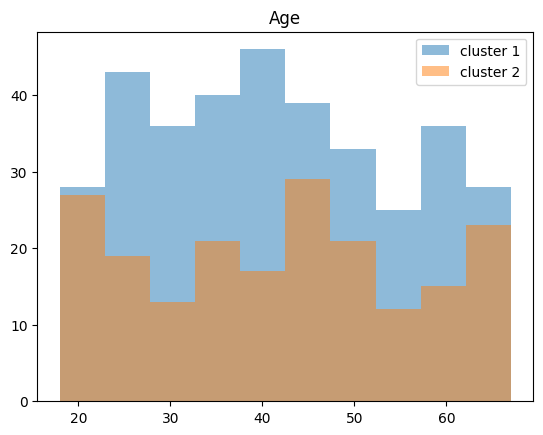

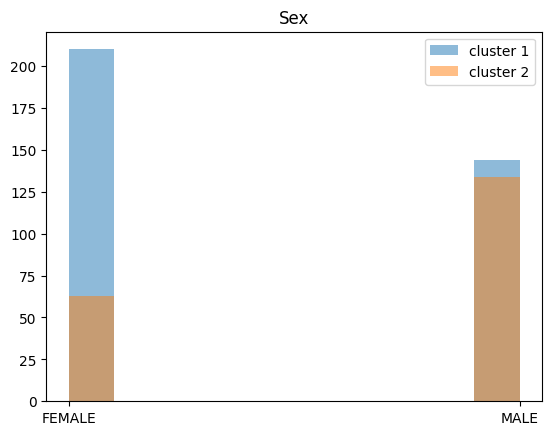

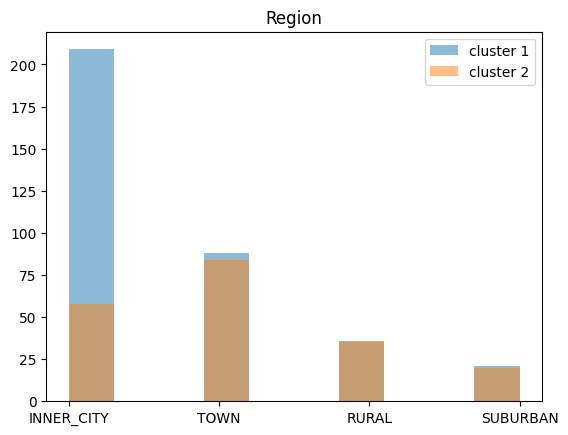

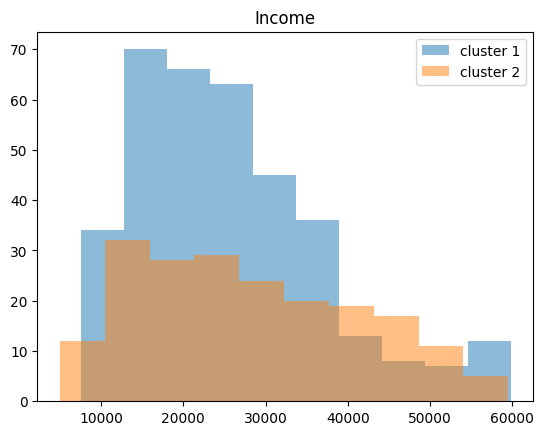

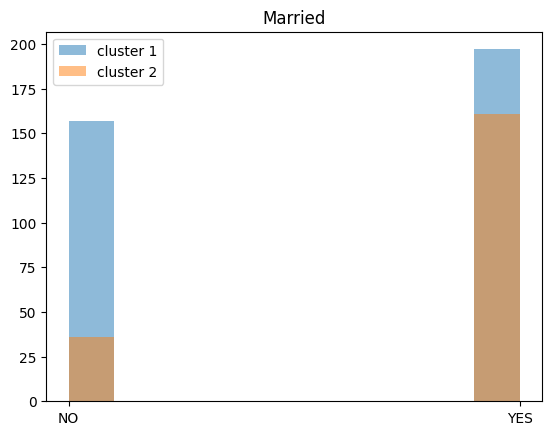

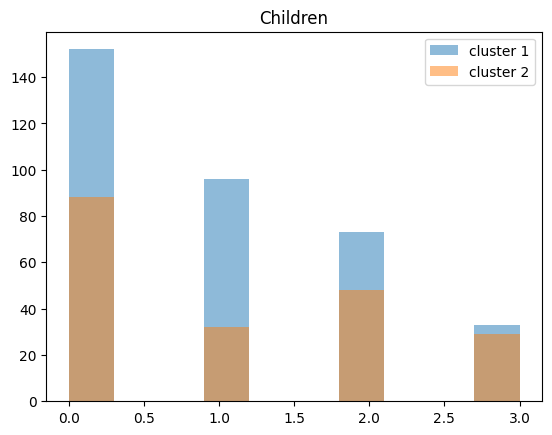

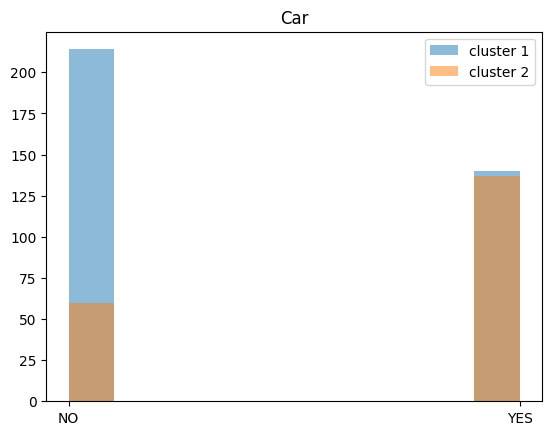

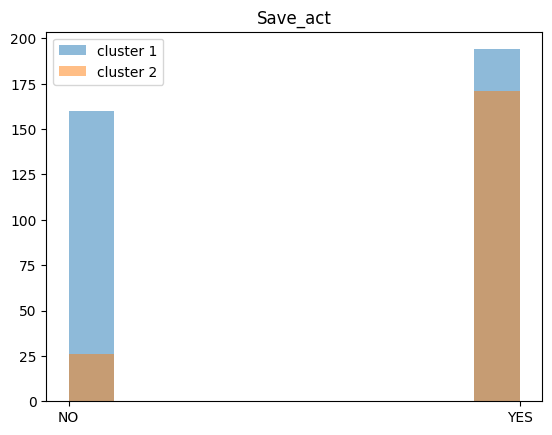

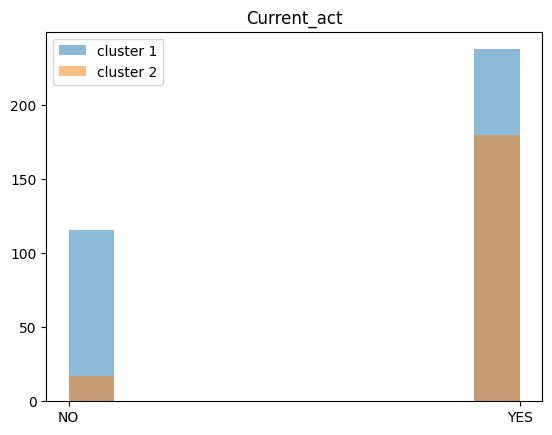

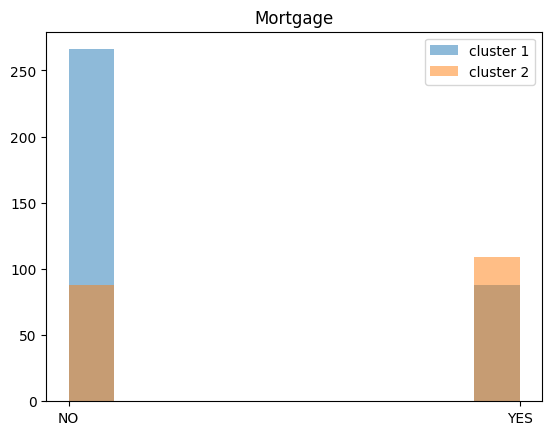

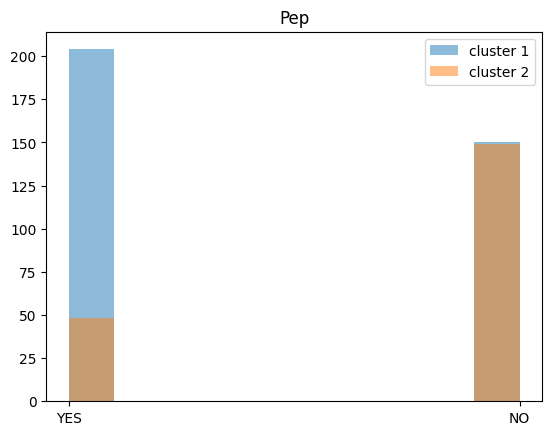

In [42]:
for column in raw_dataset.columns:
    plt.figure()
    plt.hist(cluster_1[column], alpha=0.5, label="cluster 1")
    plt.hist(cluster_2[column], alpha=0.5, label="cluster 2")
    plt.legend()
    plt.title(column.capitalize())
    plt.show()